# Benchmark clustering performance

Remember to compile `cnnclustering` with `TRACE_CYTHON=0` if timings should be measured. `TRACE_CYTHON=1` is required for line profiling and test coverage and will cause substantial overhead.

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Helper-function-definitions" data-toc-modified-id="Helper-function-definitions-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Helper function definitions</a></span><ul class="toc-item"><li><span><a href="#Benchmark-helper" data-toc-modified-id="Benchmark-helper-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Benchmark helper</a></span><ul class="toc-item"><li><span><a href="#Collect" data-toc-modified-id="Collect-1.1.1"><span class="toc-item-num">1.1.1&nbsp;&nbsp;</span>Collect</a></span></li></ul></li><li><span><a href="#Plots" data-toc-modified-id="Plots-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Plots</a></span></li><li><span><a href="#Timed-functions" data-toc-modified-id="Timed-functions-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Timed functions</a></span></li></ul></li><li><span><a href="#Runs" data-toc-modified-id="Runs-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Runs</a></span><ul class="toc-item"><li><span><a href="#Example" data-toc-modified-id="Example-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Example</a></span></li><li><span><a href="#CommonNN-Clustering" data-toc-modified-id="CommonNN-Clustering-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>CommonNN Clustering</a></span><ul class="toc-item"><li><span><a href="#Data-set:-no-structure" data-toc-modified-id="Data-set:-no-structure-2.2.1"><span class="toc-item-num">2.2.1&nbsp;&nbsp;</span>Data set: no structure</a></span></li><li><span><a href="#Run-d-f" data-toc-modified-id="Run-d-f-2.2.2"><span class="toc-item-num">2.2.2&nbsp;&nbsp;</span>Run d f</a></span></li></ul></li><li><span><a href="#CommonNN-Clustering---complete" data-toc-modified-id="CommonNN-Clustering---complete-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>CommonNN Clustering - complete</a></span><ul class="toc-item"><li><span><a href="#Data-set:-varied" data-toc-modified-id="Data-set:-varied-2.3.1"><span class="toc-item-num">2.3.1&nbsp;&nbsp;</span>Data set: varied</a></span></li></ul></li></ul></li><li><span><a href="#Scaling" data-toc-modified-id="Scaling-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Scaling</a></span></li><li><span><a href="#Plots" data-toc-modified-id="Plots-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Plots</a></span><ul class="toc-item"><li><span><a href="#Compare-parameters-for-screen" data-toc-modified-id="Compare-parameters-for-screen-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Compare parameters for screen</a></span></li><li><span><a href="#Compare-input-variations" data-toc-modified-id="Compare-input-variations-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Compare input variations</a></span></li><li><span><a href="#Compare-input-variations-(complete)" data-toc-modified-id="Compare-input-variations-(complete)-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>Compare input variations (complete)</a></span></li></ul></li><li><span><a href="#Scratch" data-toc-modified-id="Scratch-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Scratch</a></span></li></ul></div>

In [1]:
from datetime import datetime
import json
from operator import itemgetter
import os
import pathlib
import time
import timeit

import cnnclustering
from cnnclustering import cluster, hooks
from cnnclustering import _fit, _primitive_types, _types
from indirect import indirect
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes, mark_inset
from sklearn.cluster import DBSCAN
from sklearn import datasets
from sklearn.metrics import pairwise_distances
from sklearn.neighbors import KDTree
from sklearn.preprocessing import StandardScaler
from tqdm.notebook import tqdm

import cnnclustering_fit_cases as cases
import helper_base
import helper_plot
import helper_timeit

In [2]:
import importlib

In [3]:
importlib.reload(indirect)

<module 'indirect.indirect' from '/home/janjoswig/repo/Indirect/indirect/indirect.py'>

In [41]:
importlib.reload(helper_base)

<module 'helper_base' from '/home/janjoswig/repo/CommonNNClustering/docsrc/benchmark/helper_base.py'>

In [4]:
mpl.rcParams["figure.dpi"] = 300
mpl.rcParams['font.size'] = 10

In [5]:
print(f"{'Python':>20} :  ", *sys.version.splitlines())

              Python :   3.8.8 | packaged by conda-forge | (default, Feb 20 2021, 16:22:27)  [GCC 9.3.0]


In [6]:
print(f"cnnclustering :  ", cnnclustering.__version__)

cnnclustering :   0.4.3


## Helper function definitions

### Benchmark helper

#### Collect

In [7]:
def collect_timings(
        gen_func, setup_func, run_arguments_list,
        transform_func=None, timings=None, repeats=10,
        magic=True):
    """Orchestrate timings
    
    Args:
        gen_func: A function, returning data. Called with 
            run arguments "gen".
        setup_func: A function, accepting data and returning a
            function which should be timed. Called with
            run arguments "setup".
        run_argumens_list: A list of run arguments.
        
    Keyword args:
        transform_func: A function, transforming generated data before setup.
        timings: An optional timings mapping which results should
            put into.
        repeats: Repeats the timing *n* times. Using timeit -n/-r directly would
            not ensure running the setup before each timing.
    
    Returns:
        timings mapping
    """
    
    # Timed function has to be in global namespace to be discovered by %timeit magic
    global timed_args
    global timed_kwargs
    global timed_func
    
    if timings is None:
        timings = {}
    
    progress = tqdm(run_arguments_list, desc="Run completed")
    
    for run_index, arguments in enumerate(progress):
        
        gen_args, gen_kwargs = arguments.get("gen", ((), {}))
        data = gen_func(*gen_args, **gen_kwargs)
        
        if transform_func is not None:
            trans_args, trans_kwargs = arguments.get("transform", ((), {}))
            data = transform_func(data, *trans_args, **trans_kwargs)
        
        timeit_results = []
        for _ in range(repeats):
            setup_args, setup_kwargs = arguments.get("setup", ((), {}))
            timed_func = setup_func(data, *setup_args, **setup_kwargs)

            timed_args, timed_kwargs = arguments.get("timed", ((), {}))
            if magic:
                o = %timeit -n 1 -r 1 -q -o timed_func(*timed_args, **timed_kwargs)
            else:
                o = timeit.timeit(
                    "timed_func(*timed_args, **timed_kwargs)",
                    number=1,
                    globals=globals()
                    )
            timeit_results.append(o)

        run_id = arguments.get("id", str(run_index))
        tqdm.write(f"Timed run ID: {run_id:>10}    ({datetime.now().strftime('%d.%m.%Y %H:%M:%S')})")
        timings[run_id] = helper_jupyter.combine_timeit_results(*timeit_results)
        
    return timings

### Plots

In [59]:
def evaluate_timings(
        run_map,
        plot_scalings=True,
        scaling_kwargs=None,
        scaling_kwargs_map=None,
        scaling_label_map=None,
        normal_ax=None, log_ax=None,
        plot_props=None, legend_props=None):
    
    if (normal_ax is None) & (log_ax is None):
        fig, (normal_ax, log_ax) = plt.subplots(2, 1)
    elif normal_ax is not None:
        fig = normal_ax.get_figure()
    else:
        fig = log_ax.get_figure()

    if scaling_kwargs is None:
        scaling_kwargs = {}

    if scaling_kwargs_map is None:
        scaling_kwargs_map = {}

    if scaling_label_map is None:
        scaling_label_map = {}
        
    if plot_props is None:
        plot_props = {}

    default_legend_props = {
        "fancybox": False,
        "framealpha": 1,
        "edgecolor": "k",
        "fontsize": "xx-small",    
        }
        
    if legend_props is not None:
        default_legend_props.update(legend_props)
        
    fit_lines = []
    fit_legend_labels = []
    
    normal_lines = []
    log_lines = []
    
    for label, run in run_map.items():

        if plot_scalings:
            kwargs = {k: v for k, v in scaling_kwargs.items()}
            kwargs.update(scaling_kwargs_map.get(label, {}))
            (newx, fity), (popt, perr) = run.scaling(**kwargs)
            
            scaling_label = ", ".join(
                f"${symbol} = {popt[pos]:.1f} \pm {perr[pos]:.1f}$"
                for pos, symbol in scaling_label_map.items() 
                )
            if len(scaling_label) > 0:
                scaling_label = f" ({scaling_label})"
        else:
            scaling_label = ""
    
        timings = run.timings
    
        if normal_ax is not None:
            # Timings
            n_line, = helper_plot.plot_timings(
                timings,
                ax=normal_ax,
                id_to_x=lambda x: int(x),
                sort_ids=True,
                set_ax_props=False,
                plot_props=plot_props
            )
            # Scaling
            if plot_scalings:
                normal_lines.append(n_line)
                f_line, = normal_ax.plot(
                    newx, fity,
                    linestyle="--",
                    color=n_line.get_color(),
                    marker="None",
                    zorder=0
                )
            fit_legend_labels.append(label + scaling_label)
            fit_lines.append(f_line)
    
        if log_ax is not None:
            # Timings
            l_line, = helper_plot.plot_timings(
                timings,
                ax=log_ax,
                id_to_x=lambda x: int(x),
                sort_ids=True,
                set_ax_props=False,
                plot_props=plot_props
            )
            # Scaling
            if plot_scalings:
                log_lines.append(l_line)
                fl_line, = log_ax.plot(
                    newx, fity,
                    linestyle="--",
                    color=l_line.get_color(),
                    marker="None",
                    zorder=0
                )
            
            if normal_ax is None:
                fit_legend_labels.append(label + scaling_label)
                fit_lines.append(fl_line)
        
    if normal_ax is not None:
        normal_ax.set(**{
            "xlabel": None,
            "ylabel": None,
            "ylim": (0, None)
        })
            
        if log_ax is not None:
            normal_ax.xaxis.tick_top()

    if log_ax is not None:
        log_ax.set(**{
            "xlabel": None,
            "ylabel": None,
            "xscale": "log",
            "yscale": "log",
            "ylim": (1e-6, None)
        })

    if normal_ax is not None:
        legend_ax = normal_ax
        legend_lines = normal_lines
    else:
        legend_ax = log_ax
        legend_lines = log_lines

    legend = legend_ax.legend(
        legend_lines,
        fit_legend_labels,
        **default_legend_props
        )
    legend.get_frame().set_linewidth(0.5)
    
    return fig

In [9]:
def annotate_memory_error(
        ax, line, memory_error_id):
    
    last_sample_pos = line.get_xydata()[-1]
    memory_error_pos = np.array([memory_error_id, last_sample_pos[-1]])
    ax.plot(
        *np.vstack([last_sample_pos, memory_error_pos]).T,
        color="k",
        linestyle="--",
        zorder=0
    )
    ax.plot(
        *memory_error_pos,
        color=line.get_color(),
        marker="X",
        markeredgecolor="k",
        zorder=0
    )

In [10]:
marker_list = [
    "o", "v", "^", "s", "p", "P", "*", "h",
    "d", "H", "D", ">", "<", "8", "X", "o"

]
color_list = [
    '396ab1', 'da7c30', '3e9651', 'cc2529', '535154', '6b4c9a', '922428', '948b3d',
    '7293cb', 'e1974c', '84ba5b', 'd35e60', '9067a7', 'ab6857', 'ccc210', '808585'
]

### Timed functions

In [11]:
def setup_dbscan_clustering_complete(
        data):
    """Prepare benchmark of :meth:`sklearn.cluster.DBSCAN`"""

    def fit_complete(*args, **kwargs):

        clustering = DBSCAN(data)
        clustering.fit(*args, **kwargs)

    return fit_complete

## Runs

In [23]:
run_pool = indirect.Project()

In [24]:
# Machines
run_pool.add_abstraction("curta", path="reports/curta")
run_pool.add_abstraction("qcm07", path="reports/qcm07")

In [25]:
# Clustering functions
run_pool.add_abstraction("cnn", path="cnnclustering_fit", view=["curta", "qcm07"])
run_pool.add_abstraction("cnn_complete", path="cnnclustering_fit/complete", view=["curta", "qcm07"])

In [42]:
report_list = [ # keyp, data_set_name, case, addition, tags
    ("curta.cnn", "no_structure", "a_a", "_raw", ["raw"]),
    ("curta.cnn", "no_structure", "b_a", "_raw", ["raw"]),
    ("curta.cnn", "no_structure", "c_a", "_raw", ["raw"]),
    ("curta.cnn", "no_structure", "d_a", "_raw", ["raw"]),
    ("curta.cnn", "no_structure", "d_b", "_raw", ["raw"]),
    ("curta.cnn", "no_structure", "d_c", "_raw", ["raw"]),
    ("curta.cnn", "no_structure", "d_d", "_raw", ["raw"]),
    ("curta.cnn", "no_structure", "d_e", "_raw", ["raw"]),
    ("curta.cnn", "no_structure", "d_f", "_raw", ["raw"]),
    ("qcm07.cnn", "no_structure", "a_a", "", []),
    ("qcm07.cnn", "no_structure", "b_a", "", []),
    ("qcm07.cnn", "no_structure", "c_a", "", []),
    ("qcm07.cnn", "no_structure", "d_a", "", []),
    ("qcm07.cnn", "no_structure", "d_b", "", []),
    ("qcm07.cnn", "no_structure", "d_c", "", []),
    ("qcm07.cnn", "no_structure", "d_d", "", []),
    ("qcm07.cnn", "no_structure", "d_e", "", []),
    ("qcm07.cnn", "no_structure", "d_f", "", []),
    ("curta.cnn_complete", "varied", "a_a", "_raw", ["raw"]),
    ("curta.cnn_complete", "varied", "b_a", "_raw", ["raw"]),
    ("curta.cnn_complete", "varied", "c_a", "_raw", ["raw"]),
    ("qcm07.cnn_complete", "varied", "c_a", "_raw", ["raw"]),
    ]


for keyp, data_set_name, case, addition, tags in report_list:
    run_pool.add_content(
        f"{data_set_name}_{case}", f"{data_set_name}_{case}{addition}.json", tags=tags, view=[keyp]
        )
    content = run_pool[f"{keyp}.{data_set_name}_{case}"]
    
    run_pool.add_virtual(
        f"run_{data_set_name}_{case}", helper_base.Run(f"{data_set_name}_{case}"), view=[keyp],
        content=content
        )
    
    with open(content.fullpath) as report_file:
        if "raw" in tags:
            run_pool[f"{keyp}.run_{data_set_name}_{case}"].data._timings = json.load(report_file)
        else:
            timings_as_TimeitResult = json.load(
                report_file,
                object_hook=helper_timeit.as_TimeitResult
                )
            run_pool[f"{keyp}.run_{data_set_name}_{case}"].data._timings = {
                k: v.all_runs if not isinstance(v, str) else v
                for k, v in timings_as_TimeitResult.items()
                }

### Example

In [106]:
def gen_dummy():
    """Dummy data generation function"""
    return

def setup_sleep(data):
    """Dummy setup function"""
    return time.sleep

In [107]:
units = [
    helper_base.BMUnit(
        id=1,
        gen_func=gen_dummy,
        setup_func=setup_sleep,
        timed_args=(0.1,)
        ),
    helper_base.BMUnit(
        id=2,
        gen_func=gen_dummy,
        setup_func=setup_sleep,
        timed_args=(0.2,)
        )
    ]

In [108]:
print(*units)

BMUnit
    id=1
    gen_func=gen_dummy
        gen_args=()
        gen_kwargs={}
    transform_func=None
        transform_args=()
        transform_kwargs={}
    setup_func=setup_sleep
        setup_args=()
        setup_kwargs={}
    timed_args=(0.1,)
    timed_kwargs={}
 BMUnit
    id=2
    gen_func=gen_dummy
        gen_args=()
        gen_kwargs={}
    transform_func=None
        transform_args=()
        transform_kwargs={}
    setup_func=setup_sleep
        setup_args=()
        setup_kwargs={}
    timed_args=(0.2,)
    timed_kwargs={}



In [109]:
run = helper_base.Run(
    "sleep_timings",
    units
    )

run.collect(v=True)

Unit: 1
    finished 30.08.2021 11:59:23
Unit: 2
    finished 30.08.2021 11:59:25


In [110]:
print(run)

Run
    sleep_timings
    [BMUnit(id=1), BMUnit(id=2)]



In [111]:
run.timings

{1: <TimeitResult : 100 ms ± 3.31 µs per loop (mean ± std. dev. of 10 runs, 1 loop each)>,
 2: <TimeitResult : 200 ms ± 2.01 µs per loop (mean ± std. dev. of 10 runs, 1 loop each)>}

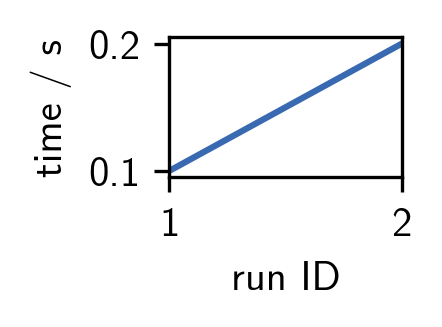

In [112]:
fig, ax = plt.subplots(figsize=(1, 1/1.618))
helper_plot.plot_timings(run.timings, ax=ax, id_to_x=lambda x: int(x))

### CommonNN Clustering

Clustering of a data sets with increasing number of points while dimensionality, cluster parameters, and cluster recipe are fixed:

  - Default recipe:
    - $d = 2$, $r = 0.25$, $c = 0$ :   (run_a_a)
    
  - Distance recipe:
    - $d = 2$, $r = 0.25$, $c = 0$ :   (run_b_a)

  - Neighbours recipe:
    - $d = 2$, $r = 0.25$, $c = 0$ :   (run_c_a)
    
  - Neighbours sorted recipe:
    - $d = 2$, $r = 0.25$, $c = 0$ :   (run_d_a)
    - $d = 2$, $r = 0.25$, $c = 50$ :  (run_d_b)
    - $d = 2$, $r = 0.25$, $c = 100$ : (run_d_c)
    - $d = 2$, $r = 0.1$, $c = 0$ :    (run_d_d)
    - $d = 2$, $r = 0.1$, $c = 50$ :   (run_d_e)
    - $d = 2$, $r = 0.1$, $c = 100$ :  (run_d_f)

#### Data set: no structure

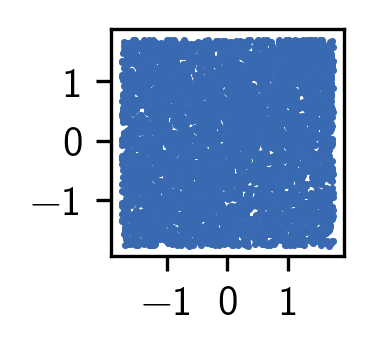

In [113]:
# The test data
fig, ax = plt.subplots(figsize=(1, 1))
ax.scatter(
    *helper_base.gen_no_structure_points((5000, 2)).T,
    s=0.5,
)

In [27]:
run_pool["curta.cnn.no_structure_a_a"].fullpath.is_file()

True

In [28]:
run = run_pool["qcm07.cnn.run_no_structure_b_a"].data
run.timings

{'500': <TimeitResult : 3.51 ms ± 679 µs per loop (mean ± std. dev. of 10 runs, 1 loop each)>,
 '1000': <TimeitResult : 17.5 ms ± 5.9 ms per loop (mean ± std. dev. of 10 runs, 1 loop each)>,
 '2000': <TimeitResult : 44.8 ms ± 17.4 ms per loop (mean ± std. dev. of 10 runs, 1 loop each)>,
 '4000': <TimeitResult : 121 ms ± 1.86 ms per loop (mean ± std. dev. of 10 runs, 1 loop each)>,
 '8000': <TimeitResult : 498 ms ± 2.82 ms per loop (mean ± std. dev. of 10 runs, 1 loop each)>,
 '16000': <TimeitResult : 2.13 s ± 12.5 ms per loop (mean ± std. dev. of 10 runs, 1 loop each)>,
 '32000': <TimeitResult : 8.5 s ± 48 ms per loop (mean ± std. dev. of 10 runs, 1 loop each)>,
 '64000': <TimeitResult : 35.1 s ± 1.34 s per loop (mean ± std. dev. of 10 runs, 1 loop each)>,
 '128000': 'MemoryError'}

In [29]:
helper_timeit.print_ratios(helper_timeit.get_ratios(run.timings, which="best"))

    Run ID: Factor
       500: 1.00
      1000: 3.76
      2000: 11.15
      4000: 42.74
      8000: 176.82
     16000: 759.19
     32000: 3029.43
     64000: 12283.38


### CommonNN Clustering - complete

#### Data set: varied

Clustering of a 2D toy data set (varied blobs) with increasing number of points while dimensionality, cluster parameters, and cluster recipe are fixed. This benchmark includes timings for preparation steps:

 - Points
    - $d = 2$, $r = 0.18$, $c = 20$ :  [run a a](#run_a_a)

 - Distances
    - $d = 2$, $r = 0.18$, $c = 20$ :  [run d b](#run_b_a)
    
 - Neighbours
    - $d = 2$, $r = 0.18$, $c = 20$ :  [run d c](#run_c_a)
    
 - Neighbours sorted
    - $d = 2$, $r = 0.18$, $c = 20$ :  [run d d](#run_d_a)

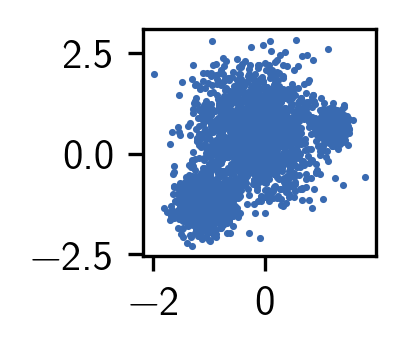

In [43]:
# The test data
fig, ax = plt.subplots(figsize=(1, 1))
ax.scatter(
    *helper_base.gen_blobs_points(
        (5000, 2), random_state=170, cluster_std=[1.0, 2.5, 0.5]
        ).T,
    s=0.5,
)

In [126]:
n_points_list = [500 * 2**x for x in range(10)]
r_list = [0.2 * 0.95**x for x in range(10)]
c_list = [int(2 * 2**x) for x in range(10)]

In [127]:
n_points_list

[500, 1000, 2000, 4000, 8000, 16000, 32000, 64000, 128000, 256000]

In [128]:
r_list

[0.2,
 0.19,
 0.1805,
 0.171475,
 0.16290125,
 0.15475618749999998,
 0.14701837812499996,
 0.13966745921874996,
 0.13268408625781244,
 0.1260498819449218]

In [131]:
c_list

[2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]

-----------------------------------------------------------------------------------------------
#points   r         c         min       max       #clusters %largest  %noise    time     
500       0.200     2         20        None      3         0.338     0.208     00:00:0.003
-----------------------------------------------------------------------------------------------

-----------------------------------------------------------------------------------------------
#points   r         c         min       max       #clusters %largest  %noise    time     
1000      0.190     4         20        None      3         0.336     0.161     00:00:0.010
-----------------------------------------------------------------------------------------------

-----------------------------------------------------------------------------------------------
#points   r         c         min       max       #clusters %largest  %noise    time     
2000      0.180     8         20        None      3         0.33

MemoryError: Unable to allocate 60.9 GiB for an array with shape (256000, 31921) and data type int64

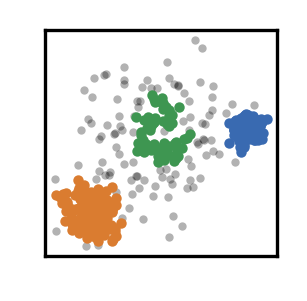

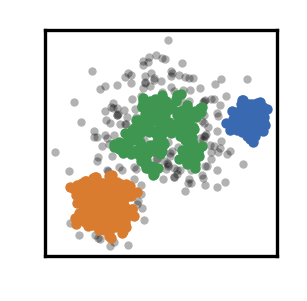

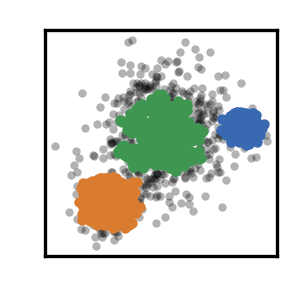

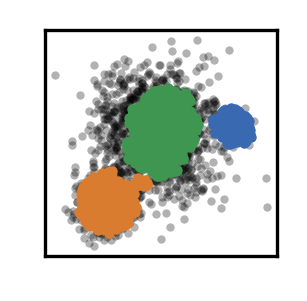

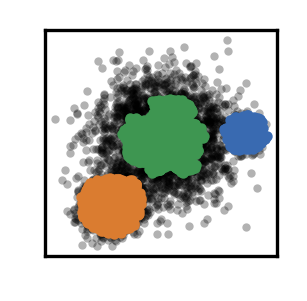

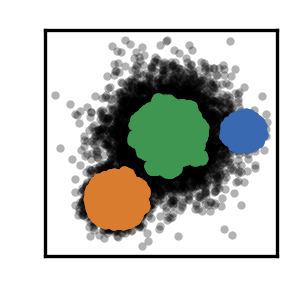

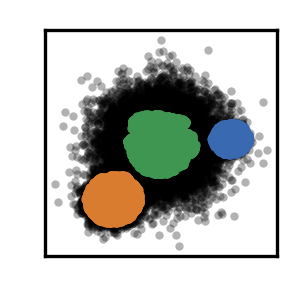

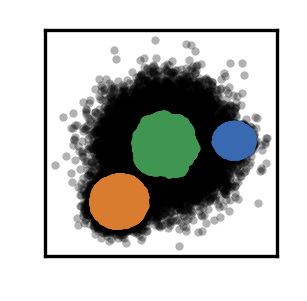

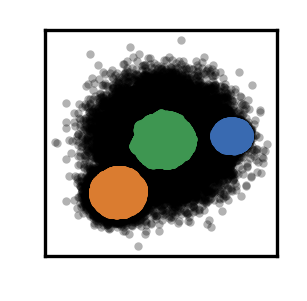

In [132]:
stop = 10
current = 0
for n, r, c in zip(n_points_list, r_list, c_list):
    current += 1
    
    points = helper_base.gen_blobs_points(
            (n, 2), random_state=170, cluster_std=[1.0, 2.5, 0.5]
            )
    
    points_clustering = cluster.ClusteringBuilder(
        points
        ).build()
    
    neighbours = helper_base.compute_neighbours(points, r)
    
    clustering = cluster.ClusteringBuilder(
        neighbours,
        preparation_hook=hooks.prepare_neighbourhoods,
        registered_recipe_key="neighbourhoods"
    ).build()
    
    clustering.fit(r, c, member_cutoff=20)
    
    points_clustering._labels = clustering._labels
    fig, ax = plt.subplots(figsize=(1, 1))
    _ = points_clustering.evaluate(
        ax=ax, annotate=False,
        ax_props={"xlabel": None, "ylabel": None, "xticks": (), "yticks": ()}
        )
    
    if current == stop:
        break

In [113]:
run_name_list = [
    ('varied_run_a_a''varied_run_a_a', report_dir_curta),
    ('varied_run_b_a', report_dir_curta),
    ('varied_run_c_a', report_dir_curta),
    ('varied_run_c_a', , report_dir_curta),
]

for run_name in run_name_list:    
    report_file = report_dir / f"{run_name}_raw.json"
    
    if not report_file.is_file():
        print(f"Not found: {report_file}")
        continue

    RUN_TIMINGS_MAP[run_name] = helper_timeit.load_report(report_file, raw=True)

## Scaling

Fit for empirical growth function:

$ t = a n^b + c$

In [64]:
run = run_pool["curta.cnn.run_no_structure_d_f"].data
run.timings

{'500': <TimeitResult : 14.7 µs ± 668 ns per loop (mean ± std. dev. of 10 runs, 1 loop each)>,
 '1000': <TimeitResult : 32.6 µs ± 542 ns per loop (mean ± std. dev. of 10 runs, 1 loop each)>,
 '2000': <TimeitResult : 85.3 µs ± 3.92 µs per loop (mean ± std. dev. of 10 runs, 1 loop each)>,
 '4000': <TimeitResult : 243 µs ± 7.31 µs per loop (mean ± std. dev. of 10 runs, 1 loop each)>,
 '8000': <TimeitResult : 786 µs ± 15.1 µs per loop (mean ± std. dev. of 10 runs, 1 loop each)>,
 '16000': <TimeitResult : 2.79 ms ± 15.1 µs per loop (mean ± std. dev. of 10 runs, 1 loop each)>,
 '32000': <TimeitResult : 54.7 ms ± 1.11 ms per loop (mean ± std. dev. of 10 runs, 1 loop each)>,
 '64000': <TimeitResult : 3.12 s ± 20 ms per loop (mean ± std. dev. of 10 runs, 1 loop each)>,
 '128000': <TimeitResult : 823 ms ± 20 ms per loop (mean ± std. dev. of 10 runs, 1 loop each)>,
 '256000': <TimeitResult : 2.41 s ± 11.3 ms per loop (mean ± std. dev. of 10 runs, 1 loop each)>}

In [65]:
run.scaling(f=helper_base.growth_with_c, p0=(0.1, 1.5, 0), maxfev=1000)

((array([   500.        ,   3080.80808081,   5661.61616162,   8242.42424242,
          10823.23232323,  13404.04040404,  15984.84848485,  18565.65656566,
          21146.46464646,  23727.27272727,  26308.08080808,  28888.88888889,
          31469.6969697 ,  34050.50505051,  36631.31313131,  39212.12121212,
          41792.92929293,  44373.73737374,  46954.54545455,  49535.35353535,
          52116.16161616,  54696.96969697,  57277.77777778,  59858.58585859,
          62439.39393939,  65020.2020202 ,  67601.01010101,  70181.81818182,
          72762.62626263,  75343.43434343,  77924.24242424,  80505.05050505,
          83085.85858586,  85666.66666667,  88247.47474747,  90828.28282828,
          93409.09090909,  95989.8989899 ,  98570.70707071, 101151.51515152,
         103732.32323232, 106313.13131313, 108893.93939394, 111474.74747475,
         114055.55555556, 116636.36363636, 119217.17171717, 121797.97979798,
         124378.78787879, 126959.5959596 , 129540.4040404 , 132121.21212121,

## Plots

In [70]:
figsrc_dir = pathlib.Path(os.path.expandvars("$WD/CommonNN/Manuscript/figsrc/Benchmark"))

### Compare parameters for screen

In [71]:
run_map = {
    "$r=0.25, c=0$": run_pool["curta.cnn.run_no_structure_d_a"].data,
    "$r=0.25, c=50$": run_pool["curta.cnn.run_no_structure_d_b"].data,
    "$r=0.25, c=100$": run_pool["curta.cnn.run_no_structure_d_c"].data,
    "$r=0.10, c=100$": run_pool["curta.cnn.run_no_structure_d_f"].data,
}

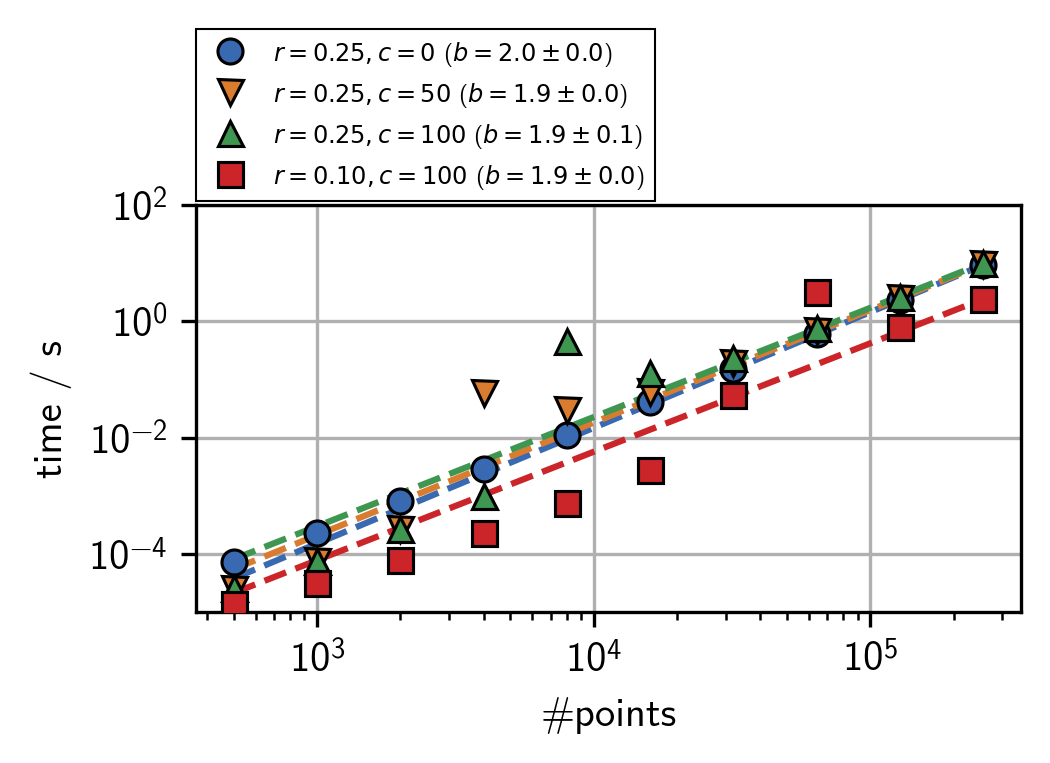

In [72]:
plt.close("all")
fig, log_ax = plt.subplots(figsize=(3.33, 3.33 / 1.4))
log_ax.grid()
log_ax.set_prop_cycle(
    marker=marker_list,
    color=color_list,
)
_ = evaluate_timings(
    run_map,
    log_ax=log_ax,
    scaling_kwargs={
        "p0": (0.1, 1.5),
        "maxfev": 1000
    },    
    scaling_kwargs_map={
        "$r=0.10, c=100$": {"mask": {"64000", "128000"}}
    },
    scaling_label_map={1: "b"},
    plot_props={
        "linestyle": "",
        "markeredgecolor": "k",
        "markeredgewidth": 0.75,
        },
    legend_props={
        "loc": (0, 1.01)
        }
    )

log_ax.set_ylim(1e-5, None)

log_ax.set_yticks((100, 1, 0.01, 0.0001))
# log_ax.set_title(" " * 20 + "")
log_ax.set_xlabel("#points")
log_ax.set_ylabel("time / s")

for c, line in enumerate(log_ax.get_lines(), 1):
    line.set_zorder(5 + 5 * (c % 2))

fig.tight_layout(pad=0.1)
# fig.savefig("/home/janjoswig/Documents/Projects/CNN/Presentation/08072021/figures/bm_no_structure_screen.png")
fig.savefig(figsrc_dir / "bm_no_structure_screen.png")

### Compare input variations

In [79]:
run_map = {
    "points $r=0.25, c=0$": run_pool["curta.cnn.run_no_structure_a_a"].data,
    "distances $r=0.25, c=0$": run_pool["curta.cnn.run_no_structure_b_a"].data,
    "neighbourhoods $r=0.25, c=0$": run_pool["curta.cnn.run_no_structure_c_a"].data,
    "neigh. sorted $r=0.25, c=0$": run_pool["curta.cnn.run_no_structure_d_a"].data,
    "neigh. sorted $r=0.1, c=0$": run_pool["curta.cnn.run_no_structure_d_d"].data,
}

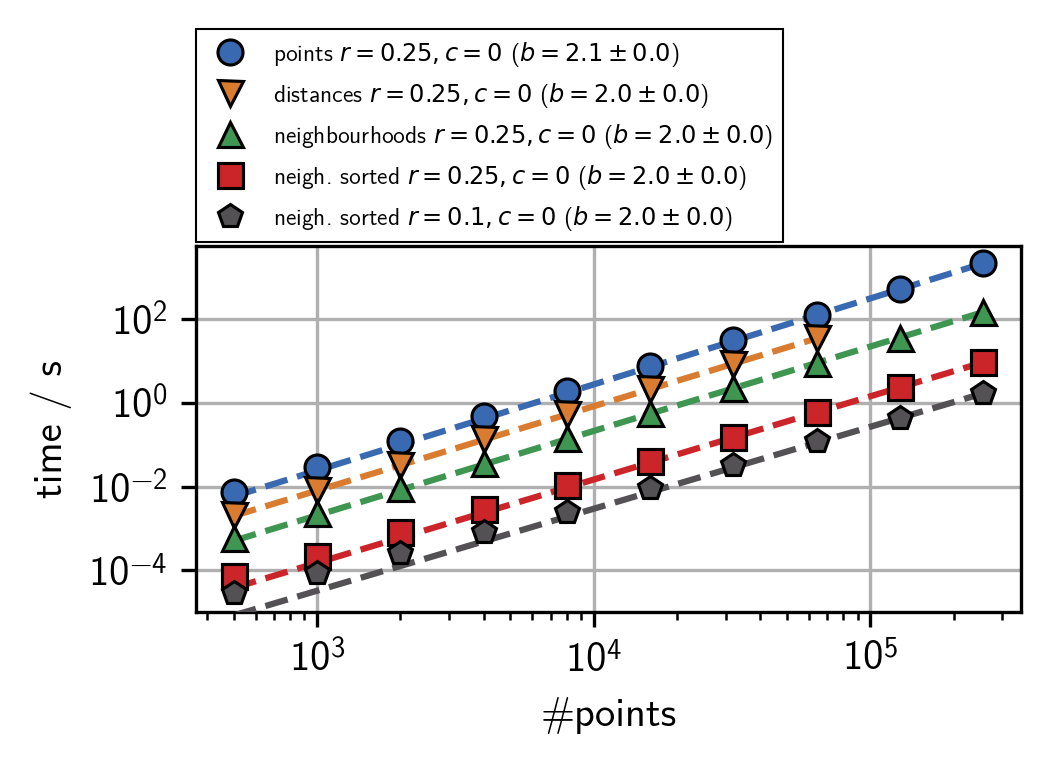

In [80]:
plt.close("all")
fig, log_ax = plt.subplots(figsize=(3.33, 3.33 / 1.4))
log_ax.grid()
log_ax.set_prop_cycle(
    marker=marker_list,
    color=color_list,
)

_ = evaluate_timings(
    run_map,
    log_ax=log_ax,
    scaling_kwargs={
        "p0": (0.1, 1.5),
        "maxfev": 1000
    },
    scaling_label_map={1: "b"},
    plot_props={
        "linestyle": "",
        "markeredgecolor": "k",
        "markeredgewidth": 0.75,
        },
    legend_props={
        "loc": (0, 1.01)
        }
    )

log_ax.set_ylim(1e-5, None)

log_ax.set_yticks((100, 1, 0.01, 0.0001))
# log_ax.set_title(" " * 20 + "")
log_ax.set_xlabel("#points")
log_ax.set_ylabel("time / s")

for c, line in enumerate(log_ax.get_lines(), 1):
    line.set_zorder(5 + 5 * (c % 2))

fig.tight_layout(pad=0.1)
# fig.savefig("/home/janjoswig/Documents/Projects/CNN/Presentation/08072021/figures/bm_no_structure_input.png")
fig.savefig(figsrc_dir / "bm_no_structure_input.png")

### Compare input variations (complete)

In [87]:
run_map = {
    "points $r=0.18, c=20$": run_pool["curta.cnn_complete.run_varied_a_a"].data,
    "distances $r=0.18, c=20$": run_pool["curta.cnn_complete.run_varied_b_a"].data,
    "neighbourhoods $r=0.18, c=20$": run_pool["curta.cnn_complete.run_varied_c_a"].data,
    # "neighbourhoods (qcm07) $r=0.18, c=20$": run_pool["qcm07.cnn_complete.run_varied_c_a"].data,
}

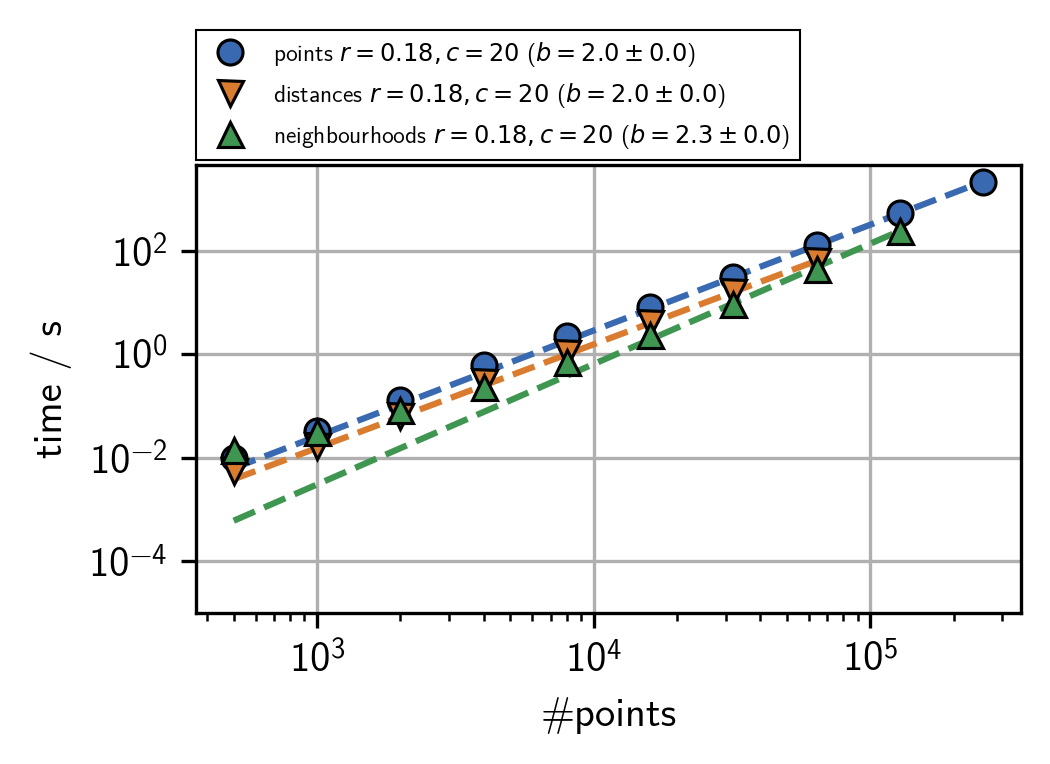

In [90]:
plt.close("all")
fig, log_ax = plt.subplots(figsize=(3.33, 3.33 / 1.4))
log_ax.grid()
log_ax.set_prop_cycle(
    marker=marker_list,
    color=color_list,
)

_ = evaluate_timings(
    run_map,
    log_ax=log_ax,
    scaling_kwargs={
        "p0": (0.1, 1.5),
        "maxfev": 1000
    },
    scaling_kwargs_map={
        "neighbourhoods $r=0.18, c=20$": {"mask": {"64000"}}
    },
    scaling_label_map={1: "b"},
    plot_props={
        "linestyle": "",
        "markeredgecolor": "k",
        "markeredgewidth": 0.75,
        },
    legend_props={
        "loc": (0, 1.01)
        }
    )

log_ax.set_ylim(1e-5, None)

log_ax.set_yticks((100, 1, 0.01, 0.0001))
# log_ax.set_title(" " * 20 + "")
log_ax.set_xlabel("#points")
log_ax.set_ylabel("time / s")

for c, line in enumerate(log_ax.get_lines(), 1):
    line.set_zorder(5 + 5 * (c % 2))

fig.tight_layout(pad=0.1)
# fig.savefig("/home/janjoswig/Documents/Projects/CNN/Presentation/08072021/figures/bm_no_structure_input.png")
fig.savefig(figsrc_dir / "bm_varied_input_complete.png")

## Scratch

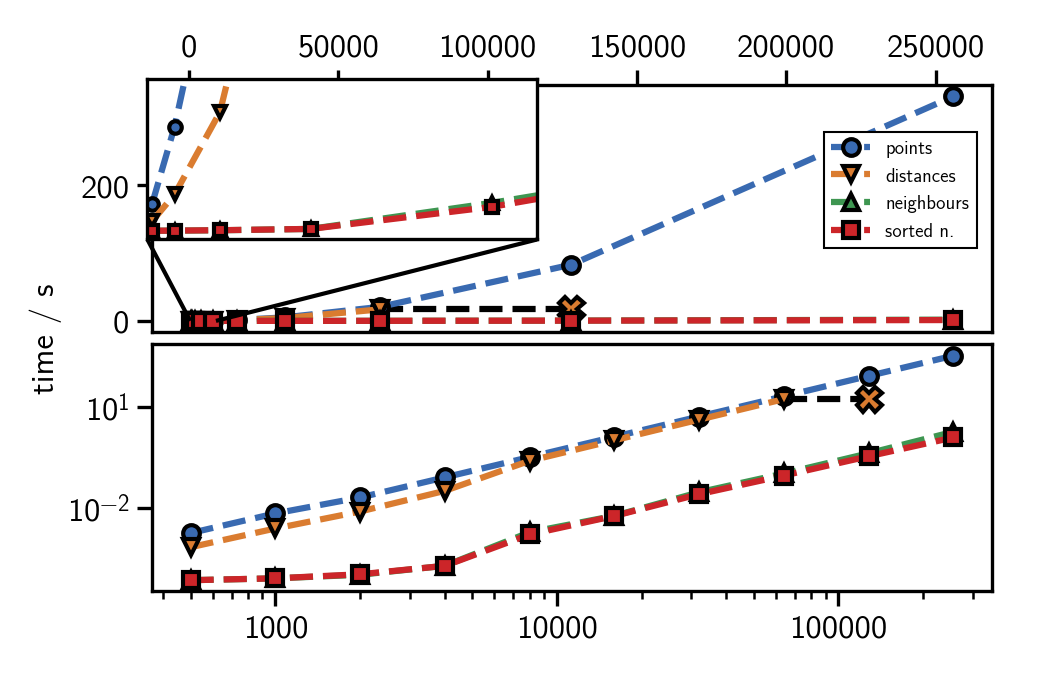

In [81]:
mpl.rcParams["font.size"] = 8
mpl.rcParams["axes.labelpad"] = 2
mpl.rcParams["xtick.major.pad"] = 2
mpl.rcParams["xtick.minor.pad"] = 1.9
mpl.rcParams["ytick.major.pad"] = 2
mpl.rcParams["ytick.minor.pad"] = 1.9

fig, (normal_ax, log_ax) = plt.subplots(2, 1, figsize=(3.33, 3.33/1.618))

run_name_list = [
    ('no_structure_run_a', 'points'),
    ('no_structure_run_b', 'distances'),
    ('no_structure_run_c', 'neighbours'),
    ('no_structure_run_d', 'sorted n.'),
]
markers = iter(["o", "v", "^", "s", "p", "P", "*", "h", "d"])

normal_ax.set_position([0.13, 0.51, 0.84, 0.40])
log_ax.set_position([0.13, 0.09, 0.84, 0.40])

# Inset
inset_ax = fig.add_axes(
    [0.125, 0.66, 0.39, 0.26],
    zorder=3,
    )

for name, label in run_name_list:
    marker = next(markers)
    
    plot_timings(
        RUN_TIMINGS_MAP[name],
        ax=normal_ax,
        id_to_x=lambda x: int(x),
        sort_ids=True,
        set_ax_props=False,
        plot_props={
            "label": label,
            "marker": marker,
            "markersize": 4
        }
    )
    
    line = normal_ax.lines[-1]
    log_line, = log_ax.plot(*line.get_xydata().T)
    saved_transform = log_line.get_transform()
    saved_clipbox = log_line.clipbox
    log_line.update_from(line)
    log_line.set_transform(saved_transform)
    log_line.clipbox = saved_clipbox
    
    line = normal_ax.lines[-1]
    inset_line, = inset_ax.plot(*line.get_xydata().T)
    saved_transform = inset_line.get_transform()
    saved_clipbox = inset_line.clipbox
    inset_line.update_from(line)
    inset_line.set_transform(saved_transform)
    inset_line.clipbox = saved_clipbox
    
    inset_line.set_markersize(3)
    
normal_ax.xaxis.tick_top()

normal_ax.set(**{
    "xlabel": None,
    "xlabel": None
})

log_ax.set(**{
    "xlabel": None,
    "xlabel": None,
    "xscale": "log",
    "yscale": "log",
})

inset_ax.set(**{
    "xlim": (400, 9000),
    "ylim": (-0.0005, 0.01),
    "xticks": (),
    "yticks": (),
})

mark_inset(normal_ax, inset_ax, loc1=3, loc2=4, edgecolor="k")

# Annotate memory error
annotate_memory_error(
    ax=normal_ax, line=normal_ax.get_lines()[1],
    memory_error_id=128000
)
annotate_memory_error(
    ax=log_ax, line=log_ax.get_lines()[1],
    memory_error_id=128000
)
    
commonax = fig.add_axes(
    [0.04, 0., 0.97, 1],
    zorder=-1,
    frame_on=False
    )

commonax.set(**{
    "xticks": (),
    "yticks": ()
})
commonax.set_ylabel("time / s", labelpad=0)

# Legend
legend = normal_ax.legend(
    fancybox=False,
    framealpha=1,
    edgecolor="k",
    fontsize="xx-small",
    loc=(0.80, 0.34)
    )
legend.get_frame().set_linewidth(0.5)

log_ax.get_xaxis().set_major_formatter(mpl.ticker.ScalarFormatter())

# fig.subplots_adjust(left=0.11, bottom=0.1, right=0.86, top=0.89, hspace=0.1)
fig.savefig(figsrc_dir / "bm_cnnclustering_fit_no_structure_a_b_c_d.png")

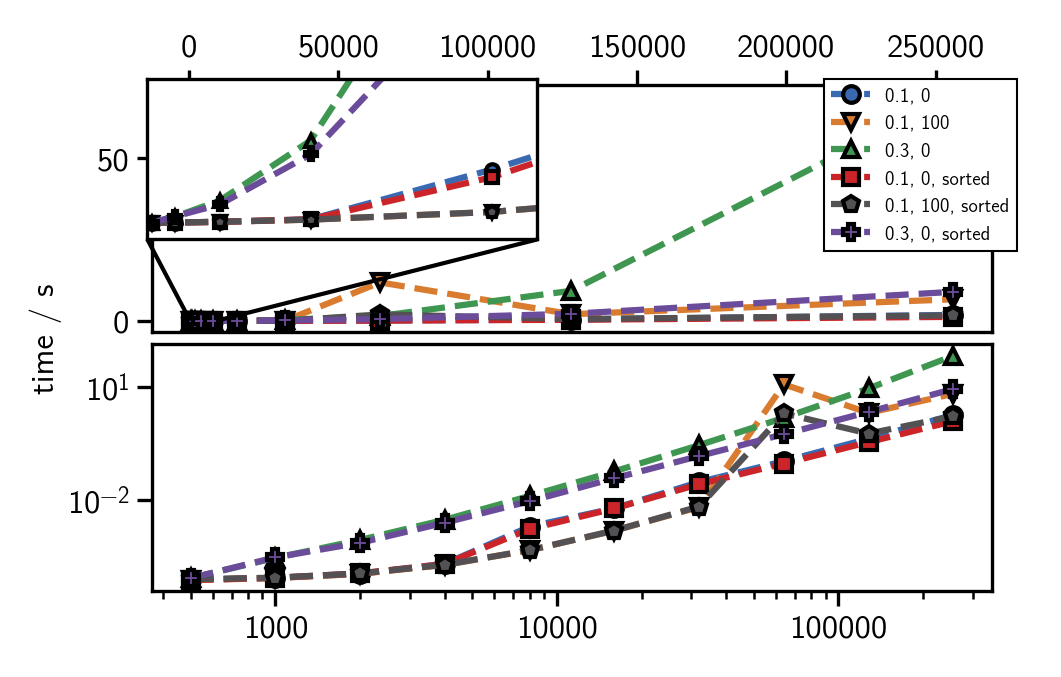

In [80]:
mpl.rcParams["font.size"] = 8
mpl.rcParams["axes.labelpad"] = 2
mpl.rcParams["xtick.major.pad"] = 2
mpl.rcParams["xtick.minor.pad"] = 1.9
mpl.rcParams["ytick.major.pad"] = 2
mpl.rcParams["ytick.minor.pad"] = 1.9

fig, (normal_ax, log_ax) = plt.subplots(2, 1, figsize=(3.33, 3.33/1.618))

run_name_list = [
    ('no_structure_run_c', '0.1, 0'),
    ('no_structure_run_c_b', '0.1, 100'),
    ('no_structure_run_c_c', '0.3, 0'),
    ('no_structure_run_d', '0.1, 0, sorted'),
    ('no_structure_run_d_b', '0.1, 100, sorted'),
    ('no_structure_run_d_c', '0.3, 0, sorted'),
]
markers = iter(["o", "v", "^", "s", "p", "P", "*", "h", "d"])

normal_ax.set_position([0.13, 0.51, 0.84, 0.40])
log_ax.set_position([0.13, 0.09, 0.84, 0.40])

# Inset
inset_ax = fig.add_axes(
    [0.125, 0.66, 0.39, 0.26],
    zorder=3,
    )

for name, label in run_name_list:
    marker = next(markers)
    
    plot_timings(
        RUN_TIMINGS_MAP[name],
        ax=normal_ax,
        id_to_x=lambda x: int(x),
        sort_ids=True,
        set_ax_props=False,
        plot_props={
            "label": label,
            "marker": marker,
            "markersize": 4
        }
    )
    
    line = normal_ax.lines[-1]
    log_line, = log_ax.plot(*line.get_xydata().T)
    saved_transform = log_line.get_transform()
    saved_clipbox = log_line.clipbox
    log_line.update_from(line)
    log_line.set_transform(saved_transform)
    log_line.clipbox = saved_clipbox
    
    line = normal_ax.lines[-1]
    inset_line, = inset_ax.plot(*line.get_xydata().T)
    saved_transform = inset_line.get_transform()
    saved_clipbox = inset_line.clipbox
    inset_line.update_from(line)
    inset_line.set_transform(saved_transform)
    inset_line.clipbox = saved_clipbox
    
    inset_line.set_markersize(3)
    
normal_ax.xaxis.tick_top()

normal_ax.set(**{
    "xlabel": None,
    "xlabel": None
})

log_ax.set(**{
    "xlabel": None,
    "xlabel": None,
    "xscale": "log",
    "yscale": "log",
})

inset_ax.set(**{
    "xlim": (400, 9000),
    "ylim": (-0.0005, 0.005),
    "xticks": (),
    "yticks": (),
})

mark_inset(normal_ax, inset_ax, loc1=3, loc2=4, edgecolor="k")
    
commonax = fig.add_axes(
    [0.04, 0., 0.97, 1],
    zorder=-1,
    frame_on=False
    )

commonax.set(**{
    "xticks": (),
    "yticks": ()
})
commonax.set_ylabel("time / s", labelpad=0)

# Legend
legend = normal_ax.legend(
    fancybox=False,
    framealpha=1,
    edgecolor="k",
    fontsize="xx-small",
    loc=(0.8, 0.33)
    )
legend.get_frame().set_linewidth(0.5)

log_ax.get_xaxis().set_major_formatter(mpl.ticker.ScalarFormatter())

# fig.subplots_adjust(left=0.11, bottom=0.1, right=0.86, top=0.89, hspace=0.1)
fig.savefig(figsrc_dir / "bm_cnnclustering_fit_no_structure_c_cb_cc_d_db_dc.png")